## V2 Efficient Net Experiment

In [1]:
import os
import sys
import yaml
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F
import time
from torch.utils.data import DataLoader

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%pip install wandb -qU
%matplotlib inline

# Get the current working directory
notebook_dir = notebook_dir = os.path.dirname(os.path.abspath("__file__"))  
project_dir = os.path.abspath(os.path.join(notebook_dir, '..')) 
if project_dir not in sys.path:
    sys.path.append(project_dir)

from src import (get_transforms, load_data, split_data, set_seeds, 
                 verify_splits, verify_data, plot_species_grid,
                 verify_loader_transforms)
from src.data_utils import ImagesDataset
from src.models import build_efficientnet_v2_basic, build_resnet50_basic
from src.train import setup_training, evaluate, evaluate_low_log, train

Note: you may need to restart the kernel to use updated packages.


### **Set up your experiment**

Copy this notebook. Rename it, but keep it in `notebooks/`. To update any settings, params, and/or hyperparams make a copy of `configs/default.yaml`, rename it and call your new `.yaml` below. Be sure to keep it in `configs/`

In [2]:
# Locate the YAML file relative to the notebook's location
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# You need to update this path to your new .yaml file
config_path = os.path.join(notebook_dir, "../configs/effnetV2_exp.yaml")

# Load the YAML file
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

In [3]:
print(torch.__version__)
print(torch.backends.mps.is_available())
device = config["device"]

2.5.1
True


### **Build the datasets**

#### Load the data
Note: your data file should be hidden in the repo (.gitignore) but make sure to set it up locally like:

`wildlife/data/givens/test_features/[images...]`

`wildlife/data/givens/train_features/[images...]`

`wildlife/data/givens/train_features.csv`

`wildlife/data/givens/test_features.csv`

In [4]:

train_features, test_features, train_labels, species_labels = load_data()

#### Augment Data

In [5]:
# Get transforms
train_transforms, val_transforms = get_transforms(config)
# print(train_transforms)
# print(val_transforms)

#### Split into train and evaluation sets

We need to ensure that sites are mutually exclusive between the training and validation sets, meaning no site should appear in both sets. This ensures a proper stratification based on site.

In [6]:
set_seeds(config["experiment"]["seed"])
X_train, X_val, y_train, y_val = split_data(
    train_features, train_labels, type='sites')

In [7]:
# Helper function (Optional)
# verify_splits(X_train, y_train, X_val,  y_val)

#### Set up DataLoader

In [8]:
set_seeds(config["experiment"]["seed"])

# Create datasets
train_dataset = ImagesDataset(
    features=X_train, 
    labels=y_train, 
    transform=train_transforms, 
    device=device)
val_dataset = ImagesDataset(
    features=X_val, 
    labels=y_val, 
    transform=val_transforms, 
    device=device)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=config["train"]["batch_size"], 
    shuffle=True, pin_memory=True)
val_loader = DataLoader(
    val_dataset, 
    batch_size=config["train"]["batch_size"], 
    shuffle=False, pin_memory=True)

In [9]:
# verify transformations in dataloaders (Optional)
# verify_loader_transforms(train_loader, title_type='train')
# verify_loader_transforms(val_loader, title_type='validate')

# set_seeds(config["experiment"]['seed'])

In [10]:
# Print shapes for verification (Optional)
print(f"Training set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")

Training set: 13171 samples
Validation set: 3317 samples


### **Training**


#### Define the model
Note: If you build a new model, add it to `models.py` and update the block below. And update your `.yaml` config.

In [11]:
set_seeds(config["experiment"]['seed'])
model = build_resnet50_basic(
    num_classes = config["model"]["num_classes"],
    hidden_units1 = config["model"]["hidden_units1"],
    dropout = config["model"]["dropout"],
    freeze_backbone = config["model"]["freeze_backbone"]
)
model = model.to(device)

freeze_backbone:  False
conv1.weight: requires_grad=True
bn1.weight: requires_grad=True
bn1.bias: requires_grad=True
layer1.0.conv1.weight: requires_grad=True
layer1.0.bn1.weight: requires_grad=True
layer1.0.bn1.bias: requires_grad=True
layer1.0.conv2.weight: requires_grad=True
layer1.0.bn2.weight: requires_grad=True
layer1.0.bn2.bias: requires_grad=True
layer1.0.conv3.weight: requires_grad=True
layer1.0.bn3.weight: requires_grad=True
layer1.0.bn3.bias: requires_grad=True
layer1.0.downsample.0.weight: requires_grad=True
layer1.0.downsample.1.weight: requires_grad=True
layer1.0.downsample.1.bias: requires_grad=True
layer1.1.conv1.weight: requires_grad=True
layer1.1.bn1.weight: requires_grad=True
layer1.1.bn1.bias: requires_grad=True
layer1.1.conv2.weight: requires_grad=True
layer1.1.bn2.weight: requires_grad=True
layer1.1.bn2.bias: requires_grad=True
layer1.1.conv3.weight: requires_grad=True
layer1.1.bn3.weight: requires_grad=True
layer1.1.bn3.bias: requires_grad=True
layer1.2.conv1.wei

In [12]:
# set_seeds(config["experiment"]['seed'])
# model =  build_efficientnet_v2_basic(
#     num_classes = config["model"]["num_classes"],
#     hidden_units1 = config["model"]["hidden_units1"],
#     dropout = config["model"]["dropout"],
#     freeze_backbone = config["model"]["freeze_backbone"]
# )
# model = model.to(device)


#### Define your criterion and optimizer
Note: If needed up date these in `train.py` and update your `.yaml` config.

In [13]:
set_seeds(config["experiment"]['seed'])
class_counts = y_train.sum(axis=0).values
# print(class_counts)

criterion, optimizer = setup_training(
        model, 
        criterion=config["train"]["criterion"],
        optimizer=config["train"]["optimizer"], 
        lr=config["train"]["lr"], 
        momentum=config["train"]["momentum"],
        gamma=config["train"]["gamma"],
        alpha=config["train"]["alpha"],
        device=device,
        cls_num_list=class_counts)
# print(config["train"]["alpha"])
# print(criterion)


#### Set up logging

In [14]:
wandb.require()
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: gball30 (gball30-georgia-institute-of-technology). Use `wandb login --relogin` to force relogin


True

In [15]:
# ✨ W&B: Initialize a new run to track this model's training
wandb.init(project="wildlife", config=config)

#### Run the train / eval loop

In [16]:

train_losses = []  # To store average training loss per epoch
val_losses = []    # To store validation loss per epoch
set_seeds(config["experiment"]['seed'])

start_time = time.time()
for epoch in range(config["train"]["epochs"]):
    # Training step
    avg_train_loss = train(model, 
                                     train_loader, 
                                     criterion, 
                                     optimizer, 
                                     epoch, config, device=device)
    train_losses.append(avg_train_loss)  # Store avg training loss
    print(f"Epoch {epoch+1}/{config["train"]["epochs"]} - Avg Train Loss: {
        avg_train_loss:.12f}")
    
    # Evaluation step
    eval_metrics = evaluate_low_log(model, val_loader, criterion, config, epoch+1, device=device)
    val_losses.append(eval_metrics["loss"])  # Store validation loss
    print(f"Epoch {epoch+1}/{config["train"]["epochs"]} - Eval Loss: {
        eval_metrics['loss']:.12f}, Eval Acc: {eval_metrics['accuracy']:.2f}%")

end_time = time.time()
duration = end_time - start_time
wandb.log({"duration": duration})


Starting training for epoch 1
Epoch [1/1], Step [100/412], Loss: 2.084595441818
Epoch [1/1], Step [200/412], Loss: 1.913063883781
Epoch [1/1], Step [300/412], Loss: 1.714728355408
Epoch [1/1], Step [400/412], Loss: 1.727943658829
Epoch 1/1 - Avg Train Loss: 1.880162797507
Eval - Loss: 1.7217, Accuracy: 36.63%, Precision: 0.29, Recall: 0.37, F1: 0.28, MacroF1: 0.25
Epoch 1/1 - Eval Loss: 1.721689135982, Eval Acc: 36.63%


If you are done logging or you want to run the experiment again, finish with the block below. But if you think you might want to submit this run to the competition, don't finish logging until the end once you've added the competition score.

In [17]:
# ✨ W&B: Mark the run as complete (Or wait until the end of notebook)
wandb.finish()

duration,▁
epoch,▁▁▁▁▁▁▁▁
eval_accuracy,▁
eval_f1,▁
eval_loss,▁
eval_macro_f1,▁
eval_precision,▁
eval_recall,▁
f1_antelope_duiker,▁
f1_bird,▁
f1_blank,▁


---


### **Explore Experiment** 

In [ ]:
# set to True to explore and potentially submit your results 
explore = False

#### Learning Curve

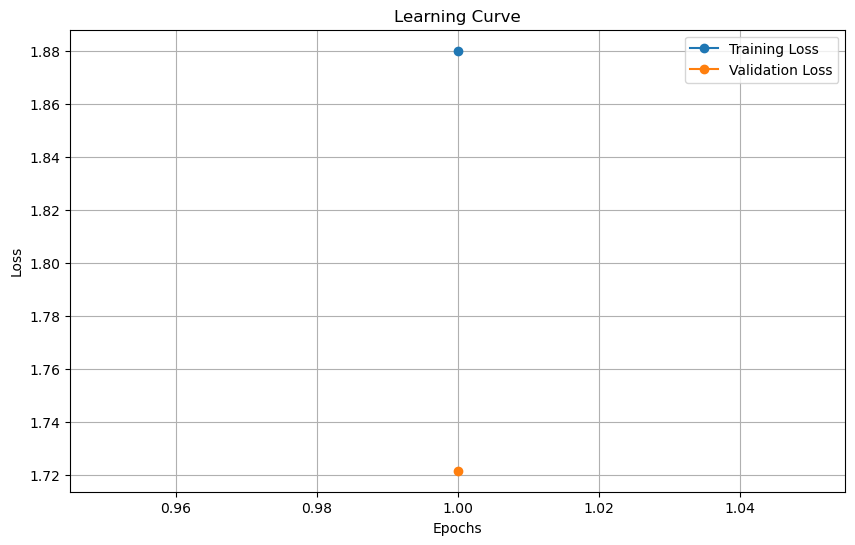

In [19]:
if explore:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, config["train"]["epochs"]+1), train_losses, label="Training Loss", marker="o")
    plt.plot(range(1, config["train"]["epochs"]+1), val_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

#### Batch Loss During Training

#### Class Distribution  

True Labels from Training Set

In [20]:
if explore:
    print("True labels (training):")
    print(y_train.idxmax(axis=1).value_counts())   

True labels (training):
civet_genet         2055
monkey_prosimian    1959
antelope_duiker     1867
leopard             1859
blank               1800
rodent              1535
bird                1324
hog                  772
Name: count, dtype: int64


True and Predicated Labels from Validation Set

In [21]:
if explore:
    # Extract predictions and true labels from eval_metrics
    all_preds = eval_metrics["all_preds"]
    all_labels = eval_metrics["all_labels"]

    # Convert all_preds to DataFrame and map to class names
    preds_df = pd.DataFrame(all_preds, columns=["predicted_class"])
    preds_df["predicted_label"] = preds_df["predicted_class"].map(
        lambda idx: species_labels[idx]
    )

    # Convert all_labels to DataFrame and map to class names
    labels_df = pd.DataFrame(all_labels, columns=["true_class"])
    labels_df["true_label"] = labels_df["true_class"].map(
        lambda idx: species_labels[idx]
    )

    # Combine predictions and true labels for analysis
    results_df = pd.concat([preds_df, labels_df], axis=1)

    # Display value counts for predicted and true labels
    print("Predicted labels (eval):")
    print(results_df["predicted_label"].value_counts())

    print("\nTrue labels (eval):")
    print(results_df["true_label"].value_counts())

Predicted labels (eval):
predicted_label
monkey_prosimian    1334
civet_genet          875
antelope_duiker      582
leopard              276
rodent               217
blank                 33
Name: count, dtype: int64

True labels (eval):
true_label
antelope_duiker     607
monkey_prosimian    533
rodent              478
blank               413
leopard             395
civet_genet         368
bird                317
hog                 206
Name: count, dtype: int64


Accuracy per class

In [22]:
if explore:    
    per_class_accuracy = results_df.groupby("true_label").apply(
        lambda x: (x["true_label"] == x["predicted_label"]).mean(), 
    )
    print("Per-Class Accuracy:")
    print(per_class_accuracy)

Per-Class Accuracy:
true_label
antelope_duiker     0.375618
bird                0.000000
blank               0.019370
civet_genet         0.959239
hog                 0.000000
leopard             0.450633
monkey_prosimian    0.806754
rodent              0.037657
dtype: float64


/var/folders/f9/_qvc3zsj1sg4_558kbgxv0d00000gn/T/ipykernel_1205/3812328652.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_class_accuracy = results_df.groupby("true_label").apply(


Confusion Matrix

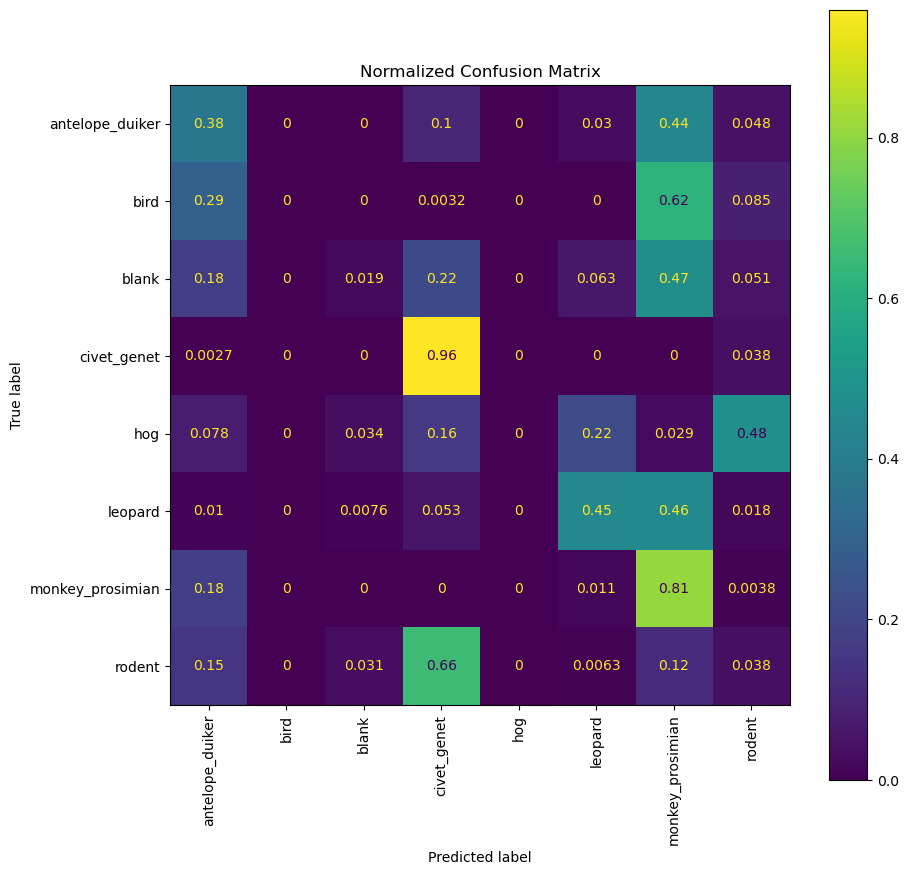

In [23]:
if explore:
    from sklearn.metrics import ConfusionMatrixDisplay

    eval_true = pd.Series(all_labels).apply(lambda x: species_labels[x])
    eval_predictions = pd.Series(all_preds).apply(lambda x: species_labels[x])

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    cm = ConfusionMatrixDisplay.from_predictions(
        eval_true,
        eval_predictions,
        ax=ax,
        xticks_rotation=90,
        colorbar=True,
        normalize='true'
    )
    plt.title("Normalized Confusion Matrix")
    plt.show()

### **Create Submission**

### Set up Datatloader

In [24]:
if explore:
    set_seeds(config["experiment"]["seed"])
    test_dataset = ImagesDataset(
        test_features, 
        transform=val_transforms, 
        device=device)

    test_loader = DataLoader(
        test_dataset, 
        batch_size=config["train"]["batch_size"], 
        shuffle=False, pin_memory=True)
    
    print(f"Test set: {len(test_dataset)} samples")

Test set: 4464 samples


### Test Model

In [25]:
if explore:
    test_preds_collector = []

    # put the model in eval mode so we don't update any parameters
    model.eval()

    # we aren't updating our weights so no need to calculate gradients
    with torch.no_grad():
        for batch_n, batch in enumerate(test_loader):
            # run the forward step
            images = batch["image"].to(device)
            logits = model(images)

            # apply softmax so that model outputs are in range [0,1]
            preds = F.softmax(logits, dim=1)

            # store this batch's predictions in df
            # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
            preds_df = pd.DataFrame(
                preds.cpu().numpy(),
                index=batch["image_id"],
                columns=species_labels,
            )
            test_preds_collector.append(preds_df)

    submission_df = pd.concat(test_preds_collector)

KeyboardInterrupt: 

Create your submission. Update submission_number.

Make sure your directory is properly set up, as both `/data` and `/results` are ignored by the repo.

In [ ]:
if explore:
    submission_number=14
    submission_df.index.name = 'id'
    submission_df = submission_df.round(6)
    submission_format_path = "../data/givens/submission_format.csv"
    submission_format = pd.read_csv(submission_format_path, index_col="id")


    assert all(submission_df.index == submission_format.index)
    assert all(submission_df.columns == submission_format.columns)

    # Save submission_df for further use
    submission_df_path = f"../results/submissions/submission{submission_number}.csv"
    submission_df.to_csv(submission_df_path)

After you submit update the submission score for logging.

In [ ]:
if explore:
     # ✨ Mannualy Log Test Results to W&B
    wandb.log({
        "test_score": 1.1850
    })

End your logging session.

In [ ]:
if explore:
    # ✨ W&B: Mark the run as complete (Or wait until the end of notebook)
    wandb.finish()